# Покупательная способность клиентов интернет-магазина💲

**Описание проекта:** Интернет-магазин продаёт различные товары: от бытовых до продуктов. Необходимо удерживать активность постоянных клиентов.

**Цель проекта:** С использованием технологий МО и анализа данных разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Ход исследования:**
- Подготовка данных: загрузка и изучение общей информации
- Предобработка данных: обработка пропущенных значений и дубликатов, корректировка типов данных, подсчет суммарных продаж по регионам
- Исследовательский анализ данных: анализ данных каждой таблицы, отбор клиентов с покупательской активностью не менее трёх месяцев
- Объединение таблиц
- Корреляционный анализ: поиск мультиколлинеарности признаков
- Создание пайплайнов
- Анализ важности признаков
- Сегментация покупателей
- Вывод

**Содержание**<a id='toc0_'></a>    
  
1. [Подготовка данных](#toc1_)                                  
  1.1 [Установка библиотек и конфигурации](#toc1_1_)    
  1.2 [Функции, используемые в проекте](#toc1_2_) 
  
2. [Предобработка данных и исследовательский анализ данных(EDA)](#toc2_)         
  2.1 [Датафрейм market_file](#toc2_1_)    
  2.2 [Датафрейм market_money](#toc2_2_)    
  2.3 [Датафрейм time_money](#toc2_3_)    
  2.4 [Датафрейм money](#toc2_4_)                                               
  2.5 [Отбор клиентов](#toc2_5_) 
  
3. [Объединение данных](#toc3_)                             

4. [Корреляционный анализ](#toc4_)  

5. [Построение моделей](#toc5_)                           
  5.1 [Подготовка данных](#toc5_1_)                     
  5.2 [Построение пайплайнов](#toc5_2_)                     
  
7. [Анализ важности признаков](#toc7_)

9. [Сегментация покупателей](#toc9_)

8. [Общий вывод](#toc8_)

## <a id='toc1_'></a> Подготовка данных[&#8593;](#toc0_)

### <a id='toc1_1_'></a>Установка библиотек  и конфигурации [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
from platform import python_version
version = python_version()

if version.startswith('3.9'):  
    pass
    %pip install --force-reinstall -v "numpy==1.22.4" -q
else: 
    pass
    %pip install --upgrade numpy -q   

%pip install --force-reinstall -v "matplotlib==3.8.0" -q

%pip install --upgrade phik -q
%pip install --upgrade prettytable -q
%pip install --upgrade termcolor -q
%pip install --upgrade seaborn -q
%pip install --upgrade pandas -q
%pip install --upgrade statsmodels -q
%pip install --upgrade scikit-learn -q
%pip install --upgrade shap -q

clear_output()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from os.path import exists
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV)
from phik import phik_matrix  # this import IS accessed
from prettytable import PrettyTable
from termcolor import colored
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)

### <a id='toc1_2_'></a>Функции, используемые в проекте [&#8593;](#toc0_)

In [5]:
def print_nans_table(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Признаки', 'Пропущенное количество значений']
    
    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'blue' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.1%})'
        table.add_row([col, colored(s, color)])
    
    print(table)

In [6]:
def the_basic_plots(df: pd.DataFrame,
                    column: str,
                    column_description: str,
                    bins: int = 25
                    ) -> None:
    
    _, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 6))

    sns.boxplot(data=df, x=column, ax=ax1)
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.histplot(data=df, x=column, bins=bins, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()
    ax2.set_ylabel('Количество')

    plt.suptitle(f'Информация о колонке {column_description}', fontsize=18)
    plt.tight_layout()

    plt.show()

In [7]:
def plot_pie_chart(series: pd.Series, title: str) -> None:
    table_1 = series.value_counts()
    data, labels = table_1.values, table_1.index
    plt.pie(data, labels=labels, autopct='%.0f%%')
    plt.title(title)
    plt.show()

In [8]:
def addlabels(data,x,y) -> None:
    for i in range(len(data)):
        plt.text(i, y[i], y[i], ha = 'center')

## <a id='toc2_'></a> Предобработка данных и исследовательский анализ данных(EDA) [&#8593;](#toc0_)

### <a id='toc2_1_'></a>Датафрейм market_file [&#8593;](#toc0_)

In [9]:
market_file = pd.read_csv('/datasets/market_file.csv')

In [10]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


1. Переименуем столбцы по стандарту:


In [11]:
market_file = market_file.rename(columns={
    'Покупательская активность': 'purchasing_activity',
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'is_mailing_allowed',
    'Маркет_актив_6_мес': 'marketing_activity_6_months',
    'Маркет_актив_тек_мес': 'marketing_activity_current_month',
    'Длительность': 'days_after_registration',
    'Акционные_покупки': 'sale_purchases_part',
    'Популярная_категория': 'most_popular_category',
    'Средний_просмотр_категорий_за_визит': 'categories_visited_per_session',
    'Неоплаченные_продукты_штук_квартал': 'unpaid_items_number',
    'Ошибка_сервиса': 'fail_number',
    'Страниц_за_визит': 'pages_per_session'
}, errors='raise')

In [12]:
market_file.columns

Index(['id', 'purchasing_activity', 'service_type', 'is_mailing_allowed',
       'marketing_activity_6_months', 'marketing_activity_current_month',
       'days_after_registration', 'sale_purchases_part',
       'most_popular_category', 'categories_visited_per_session',
       'unpaid_items_number', 'fail_number', 'pages_per_session'],
      dtype='object')

2. Проверим типы данных

In [13]:
market_file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1300 non-null   int64  
 1   purchasing_activity               1300 non-null   object 
 2   service_type                      1300 non-null   object 
 3   is_mailing_allowed                1300 non-null   object 
 4   marketing_activity_6_months       1300 non-null   float64
 5   marketing_activity_current_month  1300 non-null   int64  
 6   days_after_registration           1300 non-null   int64  
 7   sale_purchases_part               1300 non-null   float64
 8   most_popular_category             1300 non-null   object 
 9   categories_visited_per_session    1300 non-null   int64  
 10  unpaid_items_number               1300 non-null   int64  
 11  fail_number                       1300 non-null   int64  
 12  pages_

Все типы данных верны

3. Проверим пропуски

In [14]:
print_nans_table(market_file)

+----------------------------------+---------------------------------+
|             Признаки             | Пропущенное количество значений |
+----------------------------------+---------------------------------+
|                id                |             0 (0.0%)            |
|       purchasing_activity        |             0 (0.0%)            |
|           service_type           |             0 (0.0%)            |
|        is_mailing_allowed        |             0 (0.0%)            |
|   marketing_activity_6_months    |             0 (0.0%)            |
| marketing_activity_current_month |             0 (0.0%)            |
|     days_after_registration      |             0 (0.0%)            |
|       sale_purchases_part        |             0 (0.0%)            |
|      most_popular_category       |             0 (0.0%)            |
|  categories_visited_per_session  |             0 (0.0%)            |
|       unpaid_items_number        |             0 (0.0%)            |
|     

Пропуски не обнаружены

4. Посмотрим на дубликаты:

In [15]:
market_file.duplicated().sum()

0

Дубликаты так же не обнаружены

In [16]:
market_file['service_type'].value_counts()

service_type
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

В самом начале было видно, что в типах сервиса есть не совсем верная запись слова "стандарт", проверим и устраним эти ошибки: 

In [17]:
market_file.loc[market_file['service_type']=='стандартт','service_type'] = 'стандарт'

In [18]:
market_file['service_type'].value_counts()

service_type
стандарт    924
премиум     376
Name: count, dtype: int64

**Далее перейдем к исследованию распределений значений по столбцам(EDA).**

1. Столбец purchasing_activity

In [19]:
market_file['purchasing_activity'].value_counts()

purchasing_activity
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

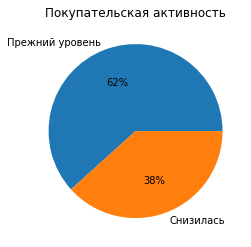

In [20]:
plot_pie_chart(market_file['purchasing_activity'], 'Покупательская активность')

Большинство покупателей продолжают быть верными интернет магазину и тратить деньги

2. Столбец service_type

In [21]:
market_file['service_type'].value_counts()

service_type
стандарт    924
премиум     376
Name: count, dtype: int64

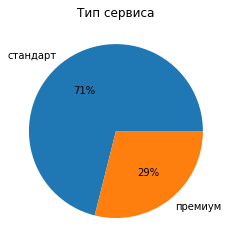

In [22]:
plot_pie_chart(market_file['service_type'], 'Тип сервиса')

Болшинство имеют стандартный тип сервиса

3. Столбец is_mailing_allowed

In [23]:
market_file['is_mailing_allowed'].value_counts()

is_mailing_allowed
да     962
нет    338
Name: count, dtype: int64

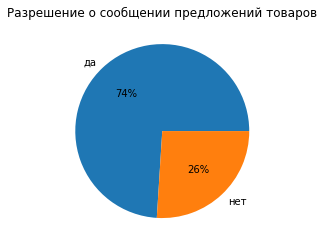

In [24]:
plot_pie_chart(market_file['is_mailing_allowed'], 'Разрешение о сообщении предложений товаров')

Большая часть людей готова принимать предложения о новых товарах

4. Столбец marketing_activity_6_months

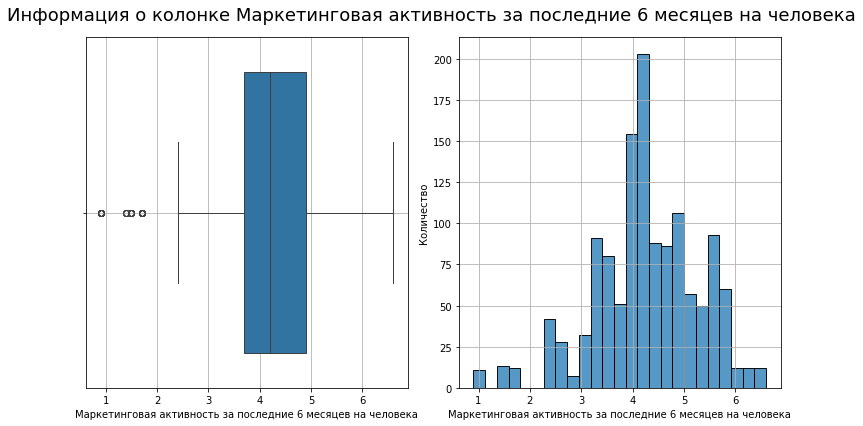

In [25]:
the_basic_plots (market_file, 'marketing_activity_6_months', 'Маркетинговая активность за последние 6 месяцев на человека')

Распределение с натяжкой можно назвать нормальным, однако категорически неприемлемых выбросов так же здесь нет.

5. Столбец marketing_activity_current_month

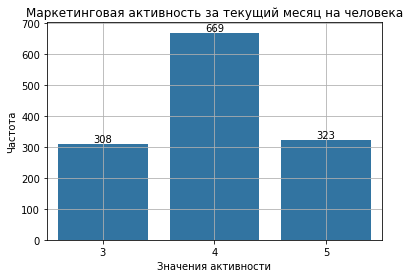

In [26]:
ax = sns.countplot(x = 'marketing_activity_current_month',  data = market_file)
plt.grid()
ax.bar_label(ax.containers[0])
plt.title('Маркетинговая активность за текущий месяц на человека')
plt.xlabel('Значения активности')
plt.ylabel('Частота')
plt.show()

Видимо четко выделенные средства на четко регламентированное количество оповещений и звонков на человека здесь дают подобные результаты

6. Столбец days_after_registration

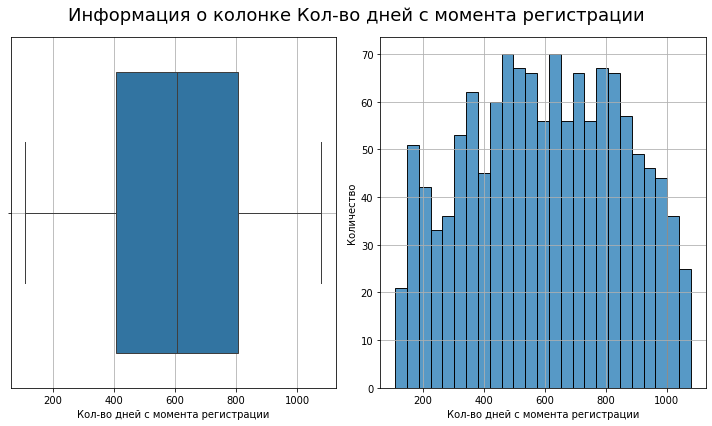

In [27]:
the_basic_plots (market_file, 'days_after_registration', 'Кол-во дней с момента регистрации')

Почти нормальное распределение

7. Столбец sale_purchases_part

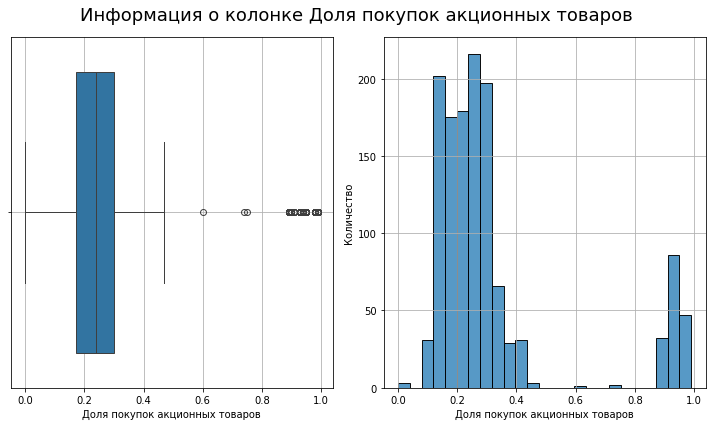

In [28]:
the_basic_plots (market_file, 'sale_purchases_part', 'Доля покупок акционных товаров')

Бимодальное распределение, обсуловленное определенным количеством людей, обращающихся в основном за акционными товарами

8. Столбец categories_visited_per_session

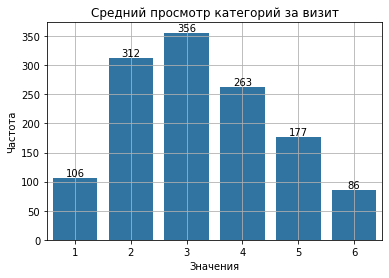

In [29]:
ax = sns.countplot(x = 'categories_visited_per_session',  data = market_file)
plt.grid()
ax.bar_label(ax.containers[0])
plt.title('Средний просмотр категорий за визит')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

дискретное распределение

9. Столбец most_popular_category 

In [30]:
market_file['most_popular_category'].value_counts()

most_popular_category
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

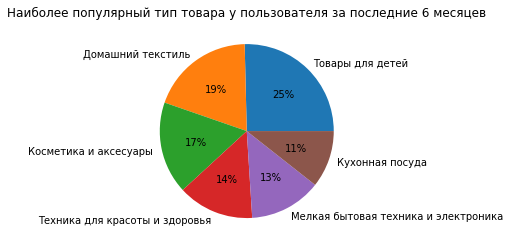

In [31]:
plot_pie_chart(market_file['most_popular_category'], 'Наиболее популярный тип товара у пользователя за последние 6 месяцев')

10. Столбец categories_visited_per_session

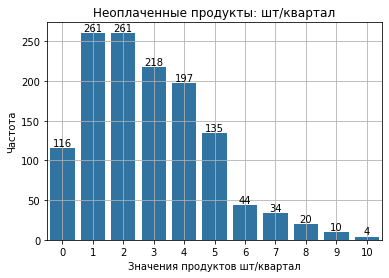

In [32]:
ax = sns.countplot(x = 'unpaid_items_number',  data = market_file)
plt.grid()
ax.bar_label(ax.containers[0])
plt.title('Неоплаченные продукты: шт/квартал')
plt.xlabel('Значения продуктов шт/квартал')
plt.ylabel('Частота')
plt.show()

Прослеживается пуассоновское распределение

11. Столбец fail_number

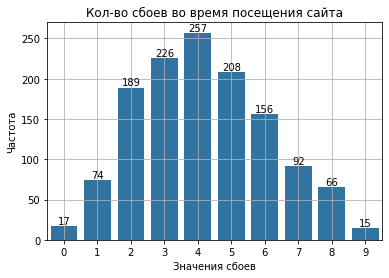

In [33]:
ax = sns.countplot(x = 'fail_number',  data = market_file)
plt.grid()
ax.bar_label(ax.containers[0])
plt.title('Кол-во сбоев во время посещения сайта')
plt.xlabel('Значения сбоев')
plt.ylabel('Частота')
plt.show()

Выбросов не наблюдаем

12. Столбец pages_per_session

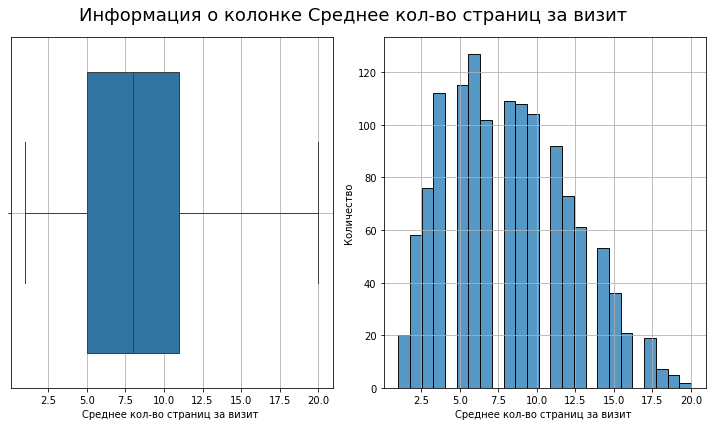

In [34]:
the_basic_plots (market_file, 'pages_per_session', 'Среднее кол-во страниц за визит ')

Так же без явных выбросов и аномалий

**Вывод**:

Данные таблицы *market_file* проанализированы и предобработаны: дубликатов и пропусков нет, тип данных корректны, выбросов также нет.

### <a id='toc2_2_'></a>Датафрейм market_money [&#8593;](#toc0_)

In [35]:
market_money = pd.read_csv('/datasets/market_money.csv')

In [36]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,3293.10
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,4472.00
4,215349,текущий_месяц,4971.60


1. Переименуем названия столбцов 

In [37]:
market_money = market_money.rename(columns={
    'Период': 'period',
    'Выручка': 'revenue'
})

In [38]:
market_money.head()

,id,period,revenue
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,3293.10
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,4472.00
4,215349,текущий_месяц,4971.60


2. Проверим типы данных

In [39]:
market_money.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


3. Проверим пропуски

In [40]:
print_nans_table(market_money)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|    id    |             0 (0.0%)            |
|  period  |             0 (0.0%)            |
| revenue  |             0 (0.0%)            |
+----------+---------------------------------+


Пропусков нет

4. Выясним, есть ли дубликаты:

In [41]:
market_money.duplicated().sum()

0

Дубликатов нет.

**Можем приступить к EDA столбцов:**

1. Столбец period

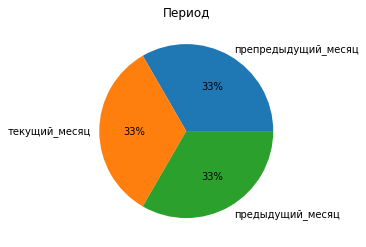

In [42]:
plot_pie_chart(market_money['period'], 'Период')

2. Столбец revenue 

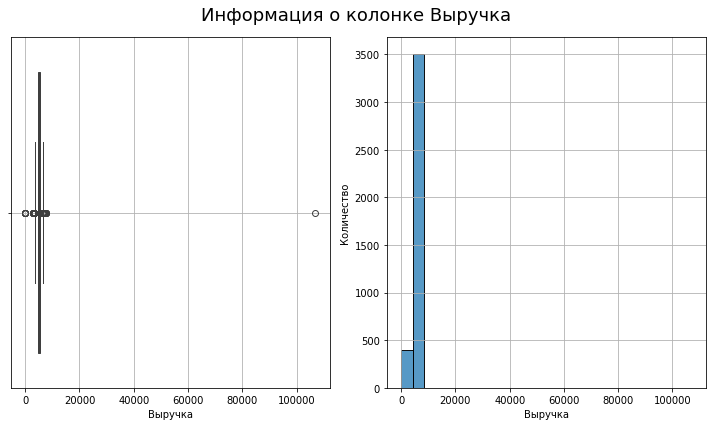

In [43]:
the_basic_plots (market_money, 'revenue', 'Выручка')

Видим сильный выброс, уберем его:

In [47]:
bad_ids_ = market_money.loc[market_money['revenue']>100000, 'id'].unique()
bad_ids_mask = market_money['id'].isin(bad_ids_)
market_money = market_money[~bad_ids_mask]

In [48]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3897 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3897 non-null   int64  
 1   period   3897 non-null   object 
 2   revenue  3897 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.8+ KB


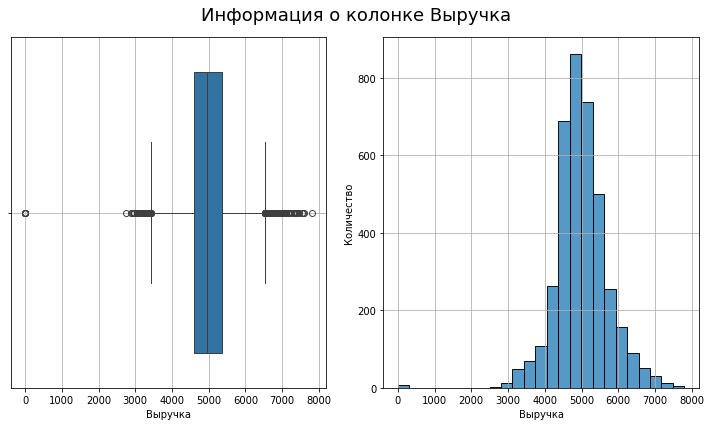

In [49]:
the_basic_plots (market_money, 'revenue', 'Выручка')

Теперь распределение похоже на нормальное

**Вывод**:


Выбросы удалены, датафрейм проверен на наличие пропусков и дубликатов, которых не оказалось.

### <a id='toc2_3_'></a> Датафрейм market_time [&#8593;](#toc0_)

In [50]:
market_time = pd.read_csv('/datasets/market_time.csv')

In [51]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [52]:
market_time = market_time.rename(columns={
    'Период': 'period',
    'минут': 'minutes'
})

In [53]:
market_time.head()

,id,period,minutes
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


В столбце *период* есть ошибка в написании, проверим и исправим ее:

In [54]:
market_time['period'].value_counts()

period
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

In [55]:
market_time.loc[market_time['period']=='предыдцщий_месяц','period'] = 'предыдущий_месяц'

In [56]:
market_time['period'].value_counts()

period
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64

Проверим типы данных:

In [57]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Пропуски и дубликаты:

In [58]:
print_nans_table(market_time)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|    id    |             0 (0.0%)            |
|  period  |             0 (0.0%)            |
| minutes  |             0 (0.0%)            |
+----------+---------------------------------+


In [59]:
market_time.duplicated().sum()

0

Пропусков и дубликатов нет.

**Перейдем к EDA:**

1. Столбец period

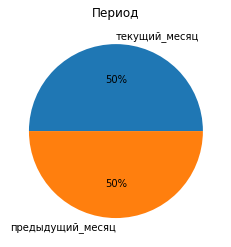

In [60]:
plot_pie_chart(market_time['period'], 'Период')

2. Столбец minutes 

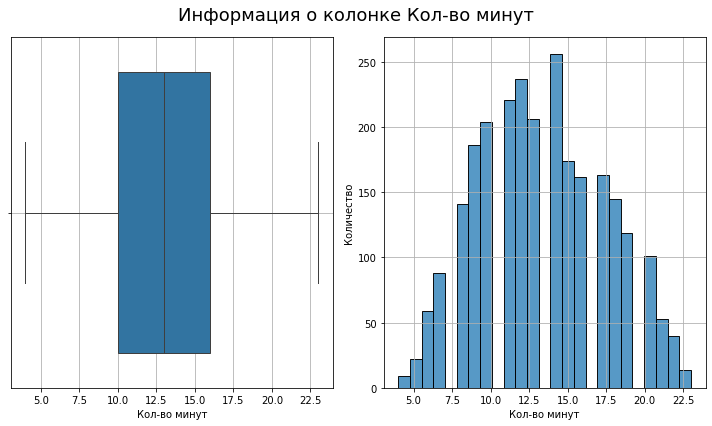

In [61]:
the_basic_plots(market_time, 'minutes', 'Кол-во минут')

**Вывод**:
Исследованы пропуски, дубликаты, синтаксические ошибки. Данные готовы к дальнейшей обработке

### <a id='toc2_4_'></a> Датафрейм  money [&#8593;](#toc0_)

In [62]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [63]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


1. Переименуем столбцы:

In [64]:
money = money.rename(columns={
    'Прибыль': 'profit'
})

In [65]:
money.head()

,id,profit
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


2. Проверим типы данных, пропуски и дубликаты:

In [66]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [67]:
money = money.set_index('id')

In [68]:
print_nans_table(money)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|  profit  |             0 (0.0%)            |
+----------+---------------------------------+


In [69]:
money.duplicated().sum()

900

Исследуем столбец с прибылью:

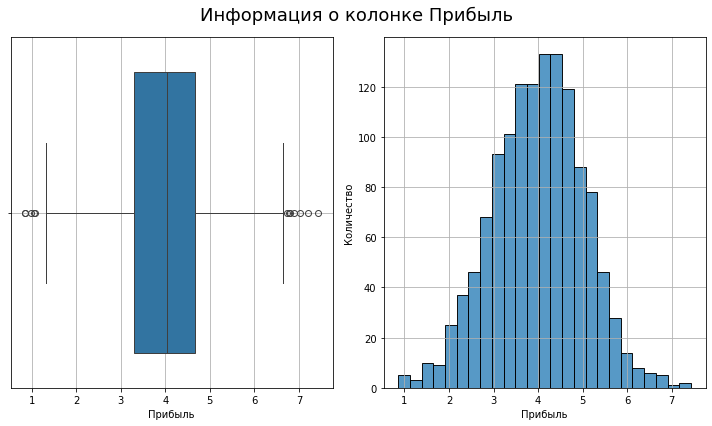

In [70]:
the_basic_plots(money, 'profit', 'Прибыль')

**Вывод**:

Близко к нормальному распределению. Критических выбросов нет. Пропуски и дубликаты не обнаружены

### <a id='toc2_5_'></a> Отбор клиентов [&#8593;](#toc0_)

Для начала составим сводные таблицы.

In [71]:
market_money = market_money.pivot_table(values='revenue', columns='period', index='id')
market_money = market_money.rename(columns={
    'предыдущий_месяц': 'money_1_month_ago',
    'препредыдущий_месяц': 'money_2_months_ago',
    'текущий_месяц': 'money_this_month' 
})
market_money.head()

period,money_1_month_ago,money_2_months_ago,money_this_month
id,,,
215348,0.00,0.00,3293.10
215349,5216.00,4472.00,4971.60
215350,5457.50,4826.00,5058.40
215351,6158.00,4793.00,6610.40
215352,5807.50,4594.00,5872.50


In [72]:
market_time = market_time.pivot_table(index='id', values='minutes', columns='period')
market_time = market_time.rename(columns={
    'предыдущий_месяц': 'time_1_month_ago',
    'текущий_месяц': 'time_this_month' 
})
market_time.head()

period,time_1_month_ago,time_this_month
id,,
215348,13.00,14.00
215349,12.00,10.00
215350,8.00,13.00
215351,11.00,13.00
215352,8.00,11.00


Такие таблицы удобны для дальнейшей работы.

Отберем клиентов с покупательной активностью не менее 3-х месяцев:

In [73]:
market_money.loc[(market_money['money_2_months_ago']==0) | (market_money['money_1_month_ago']==0)]

period,money_1_month_ago,money_2_months_ago,money_this_month
id,,,
215348,0.00,0.00,3293.10
215357,0.00,0.00,5986.30
215359,0.00,0.00,4735.00


In [74]:
market_money.shape

(1299, 3)

Уберем трех данных неактивных ранее клиентов из рассмотрения, они нам не помогут:

In [75]:
market_money = market_money.loc[(market_money['money_2_months_ago']!=0) & (market_money['money_1_month_ago']!=0)]

In [76]:
market_money.shape

(1296, 3)

Таким образом, выбраны 1296 клиентов с постоянной на протяжении 3-х месяцев покупательной активностью, учитывая, что данный месяц еще не подошел к концу.

## <a id='toc3_'></a> Объединение данных [&#8593;](#toc0_)

In [77]:
market_file = market_file.set_index('id')

In [78]:
market_full = market_money.join([market_file, market_time], how='left').sort_index(axis=1)
market_full.head()

,categories_visited_per_session,days_after_registration,fail_number,is_mailing_allowed,marketing_activity_6_months,marketing_activity_current_month,money_1_month_ago,money_2_months_ago,money_this_month,most_popular_category,pages_per_session,purchasing_activity,sale_purchases_part,service_type,time_1_month_ago,time_this_month,unpaid_items_number
id,,,,,,,,,,,,,,,,,
215349,4,819,2,да,4.40,4,5216.00,4472.00,4971.60,Товары для детей,5,Снизилась,0.75,премиум,12.00,10.00,4
215350,5,539,1,нет,4.90,3,5457.50,4826.00,5058.40,Домашний текстиль,5,Снизилась,0.14,стандарт,8.00,13.00,2
215351,5,896,6,да,3.20,5,6158.00,4793.00,6610.40,Товары для детей,4,Снизилась,0.99,стандарт,11.00,13.00,0
215352,3,1064,3,нет,5.10,3,5807.50,4594.00,5872.50,Товары для детей,2,Снизилась,0.94,стандарт,8.00,11.00,2
215353,4,762,1,да,3.30,4,4738.50,5124.00,5388.50,Домашний текстиль,4,Снизилась,0.26,стандарт,10.00,10.00,1


In [79]:
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   categories_visited_per_session    1296 non-null   int64  
 1   days_after_registration           1296 non-null   int64  
 2   fail_number                       1296 non-null   int64  
 3   is_mailing_allowed                1296 non-null   object 
 4   marketing_activity_6_months       1296 non-null   float64
 5   marketing_activity_current_month  1296 non-null   int64  
 6   money_1_month_ago                 1296 non-null   float64
 7   money_2_months_ago                1296 non-null   float64
 8   money_this_month                  1296 non-null   float64
 9   most_popular_category             1296 non-null   object 
 10  pages_per_session                 1296 non-null   int64  
 11  purchasing_activity               1296 non-null   object 
 12  sale

## <a id='toc4_'></a> Корреляционный анализ [&#8593;](#toc0_)

Чтобы провести корреляционный анализ, разделим признаки на категориальные и числовые:

In [80]:
cat_cols = ['categories_visited_per_session',
            'fail_number',
            'marketing_activity_current_month',
            'pages_per_session',
            'time_1_month_ago',
            'time_this_month',
            'unpaid_items_number',
            'is_mailing_allowed',
            'most_popular_category',
            'purchasing_activity',
            'service_type'
           ]
num_cols = ['marketing_activity_6_months', 
            'days_after_registration',
            'sale_purchases_part', 
            'money_1_month_ago', 
            'money_2_months_ago',
            'money_this_month'
           ]
display(num_cols)
display(cat_cols)

['marketing_activity_6_months',
 'days_after_registration',
 'sale_purchases_part',
 'money_1_month_ago',
 'money_2_months_ago',
 'money_this_month']

['categories_visited_per_session',
 'fail_number',
 'marketing_activity_current_month',
 'pages_per_session',
 'time_1_month_ago',
 'time_this_month',
 'unpaid_items_number',
 'is_mailing_allowed',
 'most_popular_category',
 'purchasing_activity',
 'service_type']

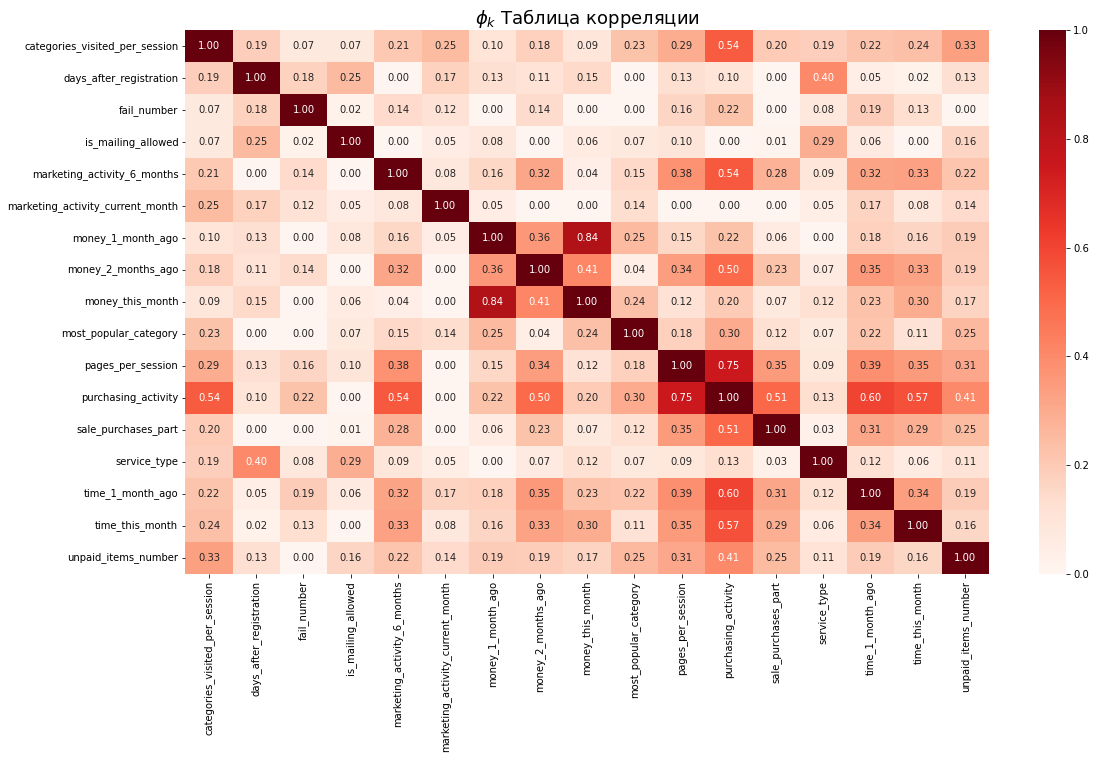

In [81]:
plt.figure(figsize=(18, 10))
sns.heatmap(market_full.phik_matrix(interval_cols=num_cols),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции', fontsize=18);

**Выводы:**

- Мультиколлинеарности не наблюдаем
- Есть корреляция между признаками money_this_month и money_1_month_ago, но она <0.9
- Так же есть корреляция между целевым признаком и кол-вом посещаемых клиентом страниц за сессию. Будем иметь это в виду
- Между остальными признаками корреляция не наблюдается

## <a id='toc5_'></a> Построение моделей [&#8593;](#toc0_)

### <a id='toc5_1_'></a> Подготовка данных[&#8593;](#toc0_)

In [82]:
target = 'purchasing_activity'

X = market_full.drop(target, axis=1)
y = market_full[target]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

Закодируем целевой признак для удобства:

In [84]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [85]:
label_encoder.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

In [86]:
y_train[:7]

array([0, 1, 0, 0, 1, 0, 1])

Кодирование прошло успешно

### <a id='toc5_2'></a> Построение пайплайнов[&#8593;](#toc0_)

Для начала разделим признаки для кодировщиков и стандартизаторов

In [87]:
ohe_cols = [
    'most_popular_category'
]

ord_cols = [
    'is_mailing_allowed',
    'service_type'
]

In [88]:
num_cols = [
    'categories_visited_per_session',
    'days_after_registration',
    'fail_number',
    'marketing_activity_6_months',
    'marketing_activity_current_month',
    'money_1_month_ago',
    'money_2_months_ago',
    'money_this_month',
    'pages_per_session',
    'sale_purchases_part',
    'time_1_month_ago',
    'time_this_month',
    'unpaid_items_number']

Пайплайны:

In [89]:
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [90]:
ord_pipe = Pipeline(
    [
        (
            'SimpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['да','нет'],
                    ['стандарт', 'премиум']
                ],
                unknown_value=np.nan,
                handle_unknown='use_encoded_value'
            )
        ),
        (
            'SimpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [91]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_cols),
     ('ord', ord_pipe, ord_cols),
     ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

In [92]:
final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [93]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel='linear',
            probability=True)],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


In [94]:
grid = GridSearchCV(
    final_pipe,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

Метрика *roc_auc* выбрана исходя из существующего у целевого признака дисбаланса классов. Она не чувствительна к дисбалансу целевого признака потому что строится относительно порога значений принадлежности к классу и инвариантна относительно данного порога (главное - сохранение соотношения ранжирования классов от наиболее вероятного отрицательного до наиболее вероятного положительного, что соблюдается).

In [95]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['most_popular_category']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('SimpleIm...
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(kernel='linear', probability=True,
                                         random_state=42)],
                          'models__C': [0.01, 0.1, 1, 10, 100],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [96]:
grid.best_score_

0.8983143201052292

In [97]:
y_pred = grid.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.9182138090037617

**Вывод**:
В данном разделе мы пользовались такими инструментами для обработки данных и поиска лучше модели:
- LabelEncoder для кодировки целевого признака
- OneHotEncoder и OrdinalEncoder для кодировки категориальных признаков
- MinMaxScaler, StandardScaler для кодировки численных признаков
- SimpleImputer для заполнения пропусков

В итоге после построения пайплайна и поиска лучшей модели через GridSearch выявлен фаворит -  LinearRegression с метрикой *roc_auc = 0,8983*

In [98]:
final_pipe_dummy = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DummyClassifier(random_state=RANDOM_STATE))
    ]
)

final_pipe_dummy.fit(X_train, y_train)
dummy_model_probas = final_pipe_dummy.predict_proba(X_test)[:,1]
dummy_roc = roc_auc_score(y_test, dummy_model_probas, )
print('ROC-AUC =', round(dummy_roc,2))

ROC-AUC = 0.5


Как мы видим, метрика показывает, что модель предсказывает случайно, то же самое, что руководствоваться подброшенной монеткой при выборе класса целевого признака, значит наша выбранная модель адекватна

## <a id='toc6_'></a> Анализ важности признаков [&#8593;](#toc0_)

In [99]:
the_best_model = grid.best_estimator_.named_steps['models']

In [100]:
X_test_transform = grid.best_estimator_.named_steps['preprocessor'].transform(X_test)

In [101]:
feature_names_ = grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

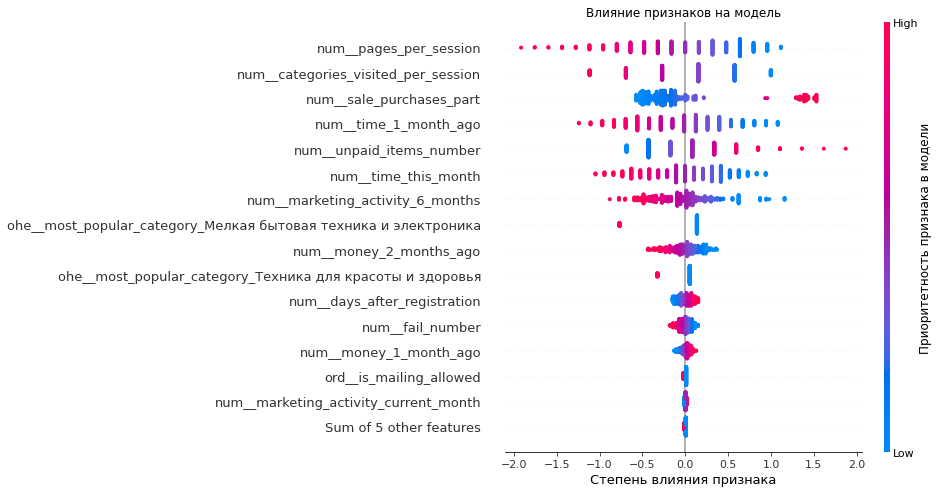

In [102]:
explainer = shap.LinearExplainer(the_best_model, X_test_transform, feature_names=feature_names_)

shap_values = explainer(X_test_transform)

shap.plots.beeswarm(shap_values, max_display=16,color_bar_label='Приоритетность признака в модели', show=False)
plt.title('Влияние признаков на модель')
plt.xlabel('Степень влияния признака')
plt.show()


По вышеприведенным данным можем сделать вывод:

- pages_per_session (кол-во страниц за визит) имеет наибольшее значение в модели, что обусловлено высокой корреляцией признака, а так же выбранной моделью-логрег и логикой.
- categories_visited_per_session (кол-во категорий за визит)  имеет также большой вес среди признаков, что так же логично, как и с предыдущим признаком: чем больше страниц и категорий просматривает человек за сессию, тем более вероятно что он заинтересован в покупках и будет продолжать покупать.
- sale_purchases_part (доля покупок по акции) влияет сильно в связи с обратной зависимостью: чем больше покупок по акции делает человек, тем ниже покупательская активность в целом.
- Явно видно, что покупательская активность за последний месяц в целом имеет большой вес, так же как и количество неоплаченных товаров.


## <a id='toc7_'></a> Сегментация покупателей [&#8593;](#toc0_)

In [103]:
df_data = grid.best_estimator_.named_steps['preprocessor'].transform(X)
df = X.copy()

df['prob_to_leave'] = the_best_model.predict_proba(df_data)[:, 1]
df['leave'] = label_encoder.transform(y)
df = df.join(money, how='left')

df.head()

,categories_visited_per_session,days_after_registration,fail_number,is_mailing_allowed,marketing_activity_6_months,marketing_activity_current_month,money_1_month_ago,money_2_months_ago,money_this_month,most_popular_category,pages_per_session,sale_purchases_part,service_type,time_1_month_ago,time_this_month,unpaid_items_number,prob_to_leave,leave,profit
id,,,,,,,,,,,,,,,,,,,
215349,4,819,2,да,4.40,4,5216.00,4472.00,4971.60,Товары для детей,5,0.75,премиум,12.00,10.00,4,0.87,1,4.16
215350,5,539,1,нет,4.90,3,5457.50,4826.00,5058.40,Домашний текстиль,5,0.14,стандарт,8.00,13.00,2,0.33,1,3.13
215351,5,896,6,да,3.20,5,6158.00,4793.00,6610.40,Товары для детей,4,0.99,стандарт,11.00,13.00,0,0.77,1,4.87
215352,3,1064,3,нет,5.10,3,5807.50,4594.00,5872.50,Товары для детей,2,0.94,стандарт,8.00,11.00,2,0.95,1,4.21
215353,4,762,1,да,3.30,4,4738.50,5124.00,5388.50,Домашний текстиль,4,0.26,стандарт,10.00,10.00,1,0.60,1,3.95


1. Выделим сегмент покупателей с высокой долей снижения покупательской активности(*prob_to_leave*>0,75) и относительно высокой(c отклонением от медианного в одну сигму) прыбылью (>3):

In [104]:
df_1seg = df.loc[(df['prob_to_leave']>0.75) & (df['profit']>3)]
df_1seg.head()

,categories_visited_per_session,days_after_registration,fail_number,is_mailing_allowed,marketing_activity_6_months,marketing_activity_current_month,money_1_month_ago,money_2_months_ago,money_this_month,most_popular_category,pages_per_session,sale_purchases_part,service_type,time_1_month_ago,time_this_month,unpaid_items_number,prob_to_leave,leave,profit
id,,,,,,,,,,,,,,,,,,,
215349,4,819,2,да,4.40,4,5216.00,4472.00,4971.60,Товары для детей,5,0.75,премиум,12.00,10.00,4,0.87,1,4.16
215351,5,896,6,да,3.20,5,6158.00,4793.00,6610.40,Товары для детей,4,0.99,стандарт,11.00,13.00,0,0.77,1,4.87
215352,3,1064,3,нет,5.10,3,5807.50,4594.00,5872.50,Товары для детей,2,0.94,стандарт,8.00,11.00,2,0.95,1,4.21
215356,2,192,1,да,4.20,4,4146.50,4433.00,4566.40,Косметика и аксесуары,3,0.14,стандарт,6.00,7.00,2,0.89,1,4.93
215362,3,438,6,да,4.20,4,4314.00,4765.00,4447.90,Домашний текстиль,4,0.74,премиум,13.00,13.00,4,0.83,1,3.49


In [105]:
len(df_1seg)

276

In [106]:
df_1seg['service_type'].value_counts()

service_type
стандарт    179
премиум      97
Name: count, dtype: int64

In [107]:
df_1seg['most_popular_category'].value_counts()

most_popular_category
Товары для детей                        90
Косметика и аксесуары                   57
Домашний текстиль                       52
Кухонная посуда                         45
Техника для красоты и здоровья          20
Мелкая бытовая техника и электроника    12
Name: count, dtype: int64

In [108]:
df_1seg['is_mailing_allowed'].value_counts()

is_mailing_allowed
да     209
нет     67
Name: count, dtype: int64

Исходя из полученных данных:

Большинство пользователей данной категории пользуются стандартным типом сервиса, покупают в основном товары для детей и косметику, а так же готовы к предложениям о новых товарах.

Можем посоветовать интернет-магазину сделать рассылки о товарах с дисконтом на наиболее популярные категории товаров почаще, тогда смогут повысить покупательскую активность данной категории покупателей. Так же стоит предложить более выгодные условия на преимиум сервис( или просто его предложить, чтобы люди были в курсе).

2. По анализу SHAP было замечено, что доля купленных по акции товаров напрямую влияет на покупательскую активность, поэтому найдем в данном сегменте покупателей с высокой долей покупок товаров по акции:

In [109]:
df_1seg_with_sales_persons_ = df_1seg.loc[df['sale_purchases_part']>0.75]
df_1seg_no_sales_persons_ = df_1seg.loc[df['sale_purchases_part']<=0.75]

In [110]:
len(df_1seg_with_sales_persons_)

98

In [111]:
len(df_1seg_no_sales_persons_)

178

In [112]:
round(df_1seg_with_sales_persons_['prob_to_leave'].mean(),3)

0.942

In [113]:
round(df_1seg_no_sales_persons_['prob_to_leave'].mean(),3)

0.892

Получается, что действительно на 5% больше среднее значение вероятности снижения покупательской активности у людей, берущих в более чем 3/4 случаев товары по акции. Стоит им предлагать больше акционных товаров в рассылках.

3. Рассмотрим долю неоплаченных товаров среди данного сегмента, а именно : посмотрим на распределение между акционными товарами и неакционными:

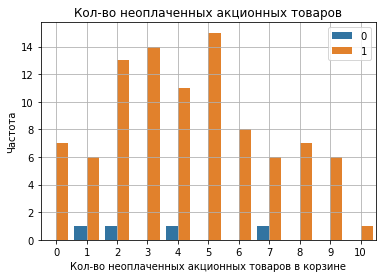

In [114]:
sns.countplot(x = 'unpaid_items_number', hue='leave', data=df_1seg_with_sales_persons_)
plt.title('Кол-во неоплаченных акционных товаров')
plt.xlabel('Кол-во неоплаченных акционных товаров в корзине')
plt.ylabel('Частота')
plt.legend()
plt.grid()
plt.show()

Что и следовало ожидать: чаще неоплаченными остаются неакционные товары. Стоит увеличивать срок акций или присылать оповещения на телефон клиенту об окончании срока акций.

Большинство покупателей, которые не оплатили акционные товары, обладают низкой покупательской активностью

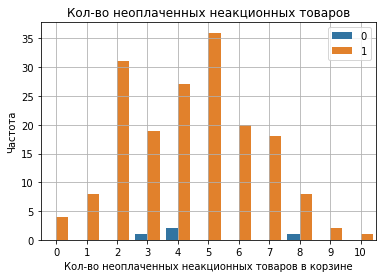

In [115]:
sns.countplot(x = 'unpaid_items_number', hue='leave', data=df_1seg_no_sales_persons_)
plt.title('Кол-во неоплаченных неакционных товаров')
plt.xlabel('Кол-во неоплаченных неакционных товаров в корзине')
plt.ylabel('Частота')
plt.legend()
plt.grid()
plt.show()

Здесь ситуация аналогичная предыдущей. В разрезе целевого признака: неоплаченные товары напрямую сказываются на снижении покупательской активности

## <a id='toc8_'></a> Общий вывод[&#8593;](#toc0_)

В ходе проекта были рассмотрены и исследованы следующие пункты:

1. Подготовка данных. Загрузили обрабатывающие библиотеки и данные.

2. Предобработка данных: В ходе предобработки все датафреймы проанализированы на пропуски, дубликаты, типы данных и выбросы. Скорректированы в соответствие с нормами и в целях корректности дальнейшего исследования.

3. Проведен исследовательский анализ данных, который показал распределения признаков в датасетах и позволил правильно структурировать некоторые из них для дальнейшего объединения и построения пайплайнов.

4. Корреляционный анализ, в ходе которого получена такая информация: 
- Мультиколлинеарности между признаками нет.
- Есть корреляция между признаками money_this_month и money_1_month_ago, но она <0.9, что объяснимо может быть сезонностью или относительно небольшой выборкой данных.
- Так же есть корреляция между целевым признаком и кол-вом посещаемых клиентом страниц за сессию, что помогло при анализе и построении модели МО.

5. Построение моделей:
- С помощью пайплайнов и GridSearchCV была найдена наилучшая модель.

- В качестве метрики была выбрана roc_auc в виду дисбаланса классов целевого признака.

Лучшей моделью стала *LogisticRegression* со значением метрики почти 0,9.

6. Исходя из анализа важности признаков методом SHAP, пришли к таким замечаниям:

- pages_per_session (кол-во страниц за визит) имеет наибольшее значение в модели, что обусловлено высокой корреляцией признака, а так же выбранной моделью-логрег и логикой.

- categories_visited_per_session (кол-во категорий за визит) имеет также большой вес среди признаков, что так же логично, как и с предыдущим признаком: чем больше страниц и категорий просматривает человек за сессию, тем более вероятно что он заинтересован в покупках и будет продолжать покупать.

- sale_purchases_part (доля покупок по акции) влияет сильно в связи с обратной зависимостью: чем больше покупок по акции делает человек, тем ниже покупательская активность в целом.

- Явно видно, что покупательская активность за последний месяц в целом имеет большой вес, так же как и количество неоплаченных товаров.

7. По анализу SHAP выделили сегмент покупателей с низкой покупательской активностью, но высокими показателями по прибыли и дали рекомендации интернет- магазину:

- Интернет-магазину стоит сделать рассылки о товарах с дисконтом на наиболее популярные категории товаров почаще, тогда смогут повысить покупательскую активность данной категории покупателей. Так же стоит предложить более выгодные условия на преимиум сервис( или просто его предложить, чтобы люди были в курсе).

- Стоит им предлагать больше акционных товаров в рассылках.

- Стоит увеличивать срок акций или присылать оповещения на телефон клиенту об окончании срока акций.